# Indiana

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import ast
from utils import *
from sklearn import preprocessing, metrics
import json
from keras.backend import squeeze, expand_dims
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_fscore_support
from keras.models import load_model
from random import shuffle
from keras import backend as K

Using TensorFlow backend.


In [2]:
#Pipeline Parameters
createEmbeddings = False
createFolds = True
workers = 3
n_epochs = 80
image_loc = '/gpfs/ysm/pi/krauthammer/kl533/Indiana_University_Chest_X-ray_Collection'
fitVerbose = 1
with open('n_splits.json') as json_file:
    json_data = json.load(json_file)
n_splits = json_data['n_splits']
channels=1
shape=(256,256)
crop=(224,224)

In [3]:
#word2vec parameters
w2v_params = {'vocabulary_size':10000, 'window_size':5,'filters':'','vector_dim':224}
#parameters
max_text_len = 200#this is the same size as the sequence length
vocabulary_size = 10000
embedding_output_dim = crop[0]#whatever the image size is

In [4]:
#build our clean csv
#load already setup csv, with clean labels
suffix = '.png'
df = load_indiana_CXR(path=image_loc)
#if label is normal 1 else 0
normal_mask = df.labels.apply(lambda x: 1 if 'normal' in x else 0)
df['normal'] = normal_mask
#add correct paths
df['img_id'] = df['img_id'].apply(lambda x: image_loc + '/images/' + x + suffix)

In [5]:
num_class = len(set(normal_mask))

In [6]:
if createEmbeddings:
    print('Section 0.5: create embeddings')
    from w2v_keras import w2v_keras
    w2v = w2v_keras(**w2v_params)
    w2v.fit(df['radiology_report'], epochs=20)
    w2v.save_embeddings('w2v_embeddings.json')

## Build our tokenizer to pass into generators

In [7]:
tokenizer = Tokenizer(num_words = vocabulary_size, lower=True, filters='')#make this a param
tokenizer.fit_on_texts(filter_sentences(df['radiology_report'].tolist()))

filtering sentences
filtering sents and removing stopwords


## Build our one hot encoder so we have a uniform encoding across all data

In [8]:
ohe = preprocessing.OneHotEncoder(categories='auto')
ohe.fit(df['normal'].to_numpy().reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

### Load Embeddings from JSON file and map tokens to embedding

In [9]:
#load embedding weights from file
location = 'w2v_embeddings.json'
import json
with open(location) as f:
    embs = json.load(f)
    emb = json.loads(embs)
embedding_weights = mapTokensToEmbedding(emb, tokenizer.word_index, 
                                         vocabulary_size)

In [10]:
from keras_applications.resnet_v2 import ResNet50V2
from keras_applications.densenet import DenseNet121
from keras.layers import GlobalAveragePooling2D, Dense
from keras import Sequential
def DenseNetModelFactory():
    model = DenseNet121(input_shape=(*crop,channels), include_top=False, weights=None,backend=keras.backend,
        layers=keras.layers,
        models=keras.models,
        utils=keras.utils)
    return model

In [11]:
from keras.models import Model
from keras.layers import Dense, Reshape, concatenate, Lambda, Average, Maximum, Add, Multiply, Concatenate, BatchNormalization, Activation, GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.embeddings import Embedding
from keras.engine.input_layer import Input
from keras.optimizers import Adam
from keras.activations import relu


def Generate_Model(model_type = 'LateFusion'):
    #set up our text input
    if model_type == 'LateFusion':
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        text_embedding = embedding(input_text)
        #set up our image branch
        image_input = Input((*crop,channels), name='image_input')
        image_branch = DenseNetModelFactory()(image_input)
        image_branch = Flatten()(image_branch)
        image_branch = Dense(1024, activation='relu', name='dense_layer1_image_branch')(image_branch)
        image_branch = BatchNormalization()(image_branch)
        image_branch = Dropout(0.5)(image_branch)        
        image_branch = Dense(512, activation='relu', name='dense_layer2_image_branch')(image_branch)
        image_branch = BatchNormalization()(image_branch)
        image_branch = Dropout(0.5)(image_branch)
        image_branch_out = Dense(num_class, activation='softmax', name='image_branch_output')(image_branch)
        image_branch_model = Model(inputs=[image_input], outputs=[image_branch_out])
        #set up text branch
        text_branch = get_text_branch()(text_embedding)
        text_branch = Dense(1024, activation='relu', name='dense_layer1_text_branch')(text_branch)
        text_branch = BatchNormalization()(text_branch)
        text_branch = Dropout(0.5)(text_branch)        
        text_branch = Dense(512, activation='relu', name='dense_layer2_text_branch')(text_branch)
        text_branch = BatchNormalization()(text_branch)
        text_branch = Dropout(0.5)(text_branch)
        text_branch_out = Dense(num_class, activation='softmax', name='text_branch_output')(text_branch)
        text_branch_model = Model(inputs=[input_text], outputs=[text_branch_out])
        outputs = [model.outputs[0] for model in [text_branch_model, image_branch_model]]
        output = Average()(outputs)
        classificationModel = Model(inputs=[text_branch_model.input, image_branch_model.input], outputs=[output])
    if model_type == "EarlyFusion":
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        text_embedding = embedding(input_text)
        if channels == 3:
            text_embedding = Lambda(embedding_3Ch)(text_embedding)
        #text_embedding = embedded_text
        #set up our image input
        image_input = Input((*crop,channels), name='image_input')
        '''merge our data for early fusion. Essentially we are just concatenating our data together'''
        if channels == 1:
            expandedText = Lambda(lambda x: expand_dims(x, axis=-1))
            text_embedding = expandedText(text_embedding)
        merged = concatenate([text_embedding, image_input], axis=1, name='merged')
        x = DenseNetModelFactory()(merged)
        x = Flatten()(x)
        x = Dense(1024, activation='relu', name='dense_layer1_earlyFusion')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_earlyFusion')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='output')(x)
        classificationModel = Model(inputs=[input_text, image_input], outputs=[output])
    if model_type == "EarlyFusion_Wide":
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        text_embedding = embedded_text
        #set up our image input
        image_input = Input((*crop,channels), name='image_input')
        image_input_reshaped = Reshape((crop[0]*channels,crop[0]))(image_input)#672 is because we have a 224x224 image with 3 channels, 224x3 channels = 627
        '''merge our data for early fusion. Essentially we are just concatenating our data together'''
        merged = concatenate([text_embedding, image_input_reshaped], axis=1, name='merged')
        x = get_text_branch()(merged)
        x = Dense(1024, activation='relu', name='dense_layer1')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='output')(x)
        classificationModel = Model(inputs=[input_text, image_input], outputs=[output])        
    if model_type == 'ModelFusion':
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        text_embedding = embedding(input_text)
        image_input = Input((*crop,channels), name='image_input')
        txt = get_text_branch()            
        #set up our image branch
        image_branch = DenseNetModelFactory()(image_input)
        image_branch = Flatten()(image_branch)
        #set up text branch
        text_branch = (txt)(text_embedding)
        #add some dense layers as test
        x = concatenate([image_branch, text_branch])
        x = Dense(1024, activation='relu', name='dense_layer1_modelFusion')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_modelFusion')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        #add some dense layers as test
        output = Dense(num_class, activation='softmax', name='output')(x)
        classificationModel = Model(inputs=[input_text, image_input], outputs=[output])
    if model_type == "text_1d":#text_1d only
        input_text = Input(shape=(max_text_len,), name='text_input')
        embedding = Embedding(input_length=max_text_len, input_dim=vocabulary_size, output_dim=embedding_output_dim, 
                               name='embedding_layer', trainable=False, weights=[embedding_weights])
        embedded_text = embedding(input_text)
        x = get_text_branch()(embedded_text)
        x = Dense(1024, activation='relu', name='dense_layer1_text_branch')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_text_branch')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='text_output')(x)
        classificationModel = Model(inputs=[input_text], outputs=[output])
    if model_type == "image":#image only
        image_input = Input((*crop,channels), name='image_input')
        x = DenseNetModelFactory()(image_input)
        x = Flatten()(x)
        x = Dense(1024, activation='relu', name='dense_layer1_image_branch')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)        
        x = Dense(512, activation='relu', name='dense_layer2_image_branch')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        output = Dense(num_class, activation='softmax', name='image_output')(x)
        classificationModel = Model(inputs=[image_input], outputs=[output])
    return classificationModel

# Set up environment for Models

In [12]:
'''
Group by label, make each label its own 'database', split databases into n chunks, for each class append ith chunk
we now have chunks which contain stratified samples. Because we split databases based on labels we may
get some samples appearing in different chunks, but will never show up in valid or test
'''

#put all labels into their own chunk, each entry contains the splits for each label, so for label 0 
#we have nsplits of label 0 at location 0
from collections import defaultdict
labelChunks = {}
stratifiedChunks = defaultdict(list)
chunks = defaultdict(dict)
for i in range(num_class):
    labelGroup = list(set(df.iloc[df.groupby(['normal']).groups[i]].sample(frac=1.0)['sample_id'].tolist()))#get all samples of that label;shuffle data
    labelChunks[i] = np.array_split(labelGroup,n_splits)#get all labels
#for each split, get the ith chunk
for split in range(n_splits):
    for label, val in labelChunks.items():
        stratifiedChunks[split].extend(val[split].tolist())
#for each chunk save its sample_id
for i, (key, chunk) in enumerate(stratifiedChunks.items()):
    chunkSampleIDs = chunk#all sample ids
    #split sample ids so we dont get any data leakage
    shuffle(chunkSampleIDs)
    train, valid, test = np.split(chunkSampleIDs, [int(.8*len(chunkSampleIDs)), int(.9*len(chunkSampleIDs))])    
    chunks[i]['train'] = train.tolist()
    chunks[i]['valid'] = valid.tolist()
    chunks[i]['test'] = test.tolist()
with open('indianaFolds.json', 'w') as fp:
    json.dump(chunks, fp)

In [13]:
with open('indianaFolds.json') as f:
    data = json.load(f)#get all of the fold information

In [14]:
chunkList = []
for ix,chunk in data.items():
    chunkList.append(chunk['train'])
    chunkList.append(chunk['valid'])
    chunkList.append(chunk['test'])
for i in range(len(chunkList)):
    for j in range(i+1, len(chunkList)):
        assert len(set(chunkList[i]).intersection(chunkList[j])) == 0, "You have an element from one chunk in another! Each chunk should have unique indicies"

# Setup our Experiments

In [15]:
from keras.optimizers import Adam
import tensorflow as tf
def optimizerFactory():
    return Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
def getCheckpointCallback(name):
    return ModelCheckpoint(name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)

### Image augmentations: to be passed in to the generator

In [17]:
#Image augmentations: to be passed in to the generator
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate,GlassBlur, ToGray
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    #VerticalFlip(p=0.5),
])

In [18]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

# Train images

In [19]:
estopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [20]:
#scheduled learning rate
lrate = ReduceLROnPlateau(monitor='val_loss',mode='min', verbose=1, patience=5)#LearningRateScheduler(step_decay)

In [21]:
#Model statistics dataframe
model_stat_df = pd.DataFrame({}, columns=['model', 'f1-score', 'precision','recall','AUC'])

In [22]:
params = {'dim': (256,256),
          'crop': (224,224),
              'batch_size': 8,
              'n_channels': 1,
              'loc': image_loc,
              'shuffle': False,
              'modality': ['image'],
              'tokenizer':tokenizer,
               'ohe': ohe}
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='image')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'imageOnly_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('imageOnly_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_Image_only.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
    

report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"Image only", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

W0331 04:41:52.908298 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0331 04:41:52.909206 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0331 04:41:52.929116 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0331 04:41:52.929787 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tens

====================Starting Split Number 0====================


W0331 04:41:54.214358 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0331 04:41:54.314000 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0331 04:41:55.322691 47808876704640 deprecation_wrapper.py:119] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0331 04:42:10.556228 47808876704640 deprecation.py:506] From /gpfs/ysm/project/kl533/conda_envs/dlnn/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.

Epoch 1/80
744/744 [==============================] - 149s 201ms/step - loss: 1.1137 - acc: 0.5254 - val_loss: 0.8261 - val_acc: 0.5829

Epoch 00001: val_loss improved from inf to 0.82607, saving model to imageOnly_split_0.hd5
Epoch 2/80
744/744 [==============================] - 115s 155ms/step - loss: 0.9522 - acc: 0.5709 - val_loss: 0.6708 - val_acc: 0.6382

Epoch 00002: val_loss improved from 0.82607 to 0.67075, saving model to imageOnly_split_0.hd5
Epoch 3/80
744/744 [==============================] - 115s 154ms/step - loss: 0.9018 - acc: 0.5711 - val_loss: 0.7438 - val_acc: 0.6342

Epoch 00003: val_loss did not improve from 0.67075
Epoch 4/80
744/744 [==============================] - 116s 155ms/step - loss: 0.8653 - acc: 0.5724 - val_loss: 0.6760 - val_acc: 0.6724

Epoch 00004: val_loss did not improve from 0.67075
Epoch 5/80
744/744 [==============================] - 115s 155ms/step - loss: 0.8183 - acc: 0.5845 - val_loss: 0.6358 - val_acc: 0.6487

Epoch 00005: val_loss improve

## Text only

In [23]:
params = {'dim': (256,256),
          'crop': (224,224),
              'batch_size': 8,
              'n_channels': 1,
              'loc': image_loc,
              'shuffle': False,
              'modality': ['text'],
              'tokenizer':tokenizer,
               'ohe': ohe}
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='text_1d')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'textOnly_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('textOnly_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_Text_only.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"Text_only", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 25s 33ms/step - loss: 0.9625 - acc: 0.6378 - val_loss: 0.4978 - val_acc: 0.7566

Epoch 00001: val_loss improved from inf to 0.49776, saving model to textOnly_split_0.hd5
Epoch 2/80
744/744 [==============================] - 21s 28ms/step - loss: 0.7721 - acc: 0.6895 - val_loss: 0.5073 - val_acc: 0.7421

Epoch 00002: val_loss did not improve from 0.49776
Epoch 3/80
744/744 [==============================] - 22s 29ms/step - loss: 0.6755 - acc: 0.7241 - val_loss: 0.3897 - val_acc: 0.8145

Epoch 00003: val

# Train multimodal Models

In [24]:
params = {'dim': (256,256),
          'crop': (224,224),
              'batch_size': 8,
              'n_channels': 1,
              'loc': image_loc,
              'shuffle': False,
              'modality': ['image', 'text'],
              'tokenizer':tokenizer,
               'ohe': ohe}

## Model Fusion Randomly Initialized

In [25]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='ModelFusion')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'modelFusion_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('modelFusion_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_ModelFusion.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
    
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"ModelFusion", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 142s 190ms/step - loss: 0.9976 - acc: 0.6126 - val_loss: 0.6938 - val_acc: 0.6737

Epoch 00001: val_loss improved from inf to 0.69379, saving model to modelFusion_split_0.hd5
Epoch 2/80
744/744 [==============================] - 109s 146ms/step - loss: 0.7630 - acc: 0.6919 - val_loss: 0.4144 - val_acc: 0.8184

Epoch 00002: val_loss improved from 0.69379 to 0.41442, saving model to modelFusion_split_0.hd5
Epoch 3/80
744/744 [==============================] - 112s 150ms/step - loss: 0.5737 - acc: 0.7717 

## Model Fusion Pretrained

In [26]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='ModelFusion')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'modelFusion_PT_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    
    #Load weights
    model.layers[2].set_weights(load_model('imageOnly_split_{}.hd5'.format(ix),compile=False).layers[1].get_weights())#image
    model.layers[5].set_weights(load_model('textOnly_split_{}.hd5'.format(ix),compile=False).layers[2].get_weights())#text
    
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('modelFusion_PT_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_ModelFusion_PT.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"ModelFusion_PT", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 159s 214ms/step - loss: 0.7589 - acc: 0.7122 - val_loss: 0.3962 - val_acc: 0.8355

Epoch 00001: val_loss improved from inf to 0.39624, saving model to modelFusion_PT_split_0.hd5
Epoch 2/80
744/744 [==============================] - 127s 171ms/step - loss: 0.4769 - acc: 0.8179 - val_loss: 0.2359 - val_acc: 0.9013

Epoch 00002: val_loss improved from 0.39624 to 0.23592, saving model to modelFusion_PT_split_0.hd5
Epoch 3/80
744/744 [==============================] - 128s 172ms/step - loss: 0.4092 - acc: 0

## Late Fusion Randomly Initialized

In [27]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='LateFusion')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'lateFusion_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('lateFusion_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_LateFusion.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
    
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"LateFusion", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 160s 216ms/step - loss: 0.7241 - acc: 0.6500 - val_loss: 0.5276 - val_acc: 0.7355

Epoch 00001: val_loss improved from inf to 0.52761, saving model to lateFusion_split_0.hd5
Epoch 2/80
744/744 [==============================] - 126s 169ms/step - loss: 0.6221 - acc: 0.7127 - val_loss: 0.5423 - val_acc: 0.7684

Epoch 00002: val_loss did not improve from 0.52761
Epoch 3/80
744/744 [==============================] - 127s 171ms/step - loss: 0.5459 - acc: 0.7666 - val_loss: 0.4621 - val_acc: 0.8118

Epoch 00

## Late Fusion Pretrained

In [28]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='LateFusion')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'lateFusion_PT_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    #Load weights: This will only load the feature extractors, not the 2 dense layers at the end.
    model.layers[3].set_weights(load_model('imageOnly_split_{}.hd5'.format(ix),compile=False).layers[1].get_weights())#image
    model.layers[4].set_weights(load_model('textOnly_split_{}.hd5'.format(ix),compile=False).layers[2].get_weights())#text
    
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('lateFusion_PT_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_Late_Fusion_PT.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
    
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"Late_Fusion_PT", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 158s 213ms/step - loss: 0.5361 - acc: 0.7895 - val_loss: 0.4098 - val_acc: 0.8842

Epoch 00001: val_loss improved from inf to 0.40977, saving model to lateFusion_PT_split_0.hd5
Epoch 2/80
744/744 [==============================] - 127s 171ms/step - loss: 0.4406 - acc: 0.8642 - val_loss: 0.3480 - val_acc: 0.9092

Epoch 00002: val_loss improved from 0.40977 to 0.34798, saving model to lateFusion_PT_split_0.hd5
Epoch 3/80
744/744 [==============================] - 127s 171ms/step - loss: 0.4010 - acc: 0.8

## Early Fusion

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 185s 248ms/step - loss: 0.9506 - acc: 0.6171 - val_loss: 0.5412 - val_acc: 0.7342

Epoch 00001: val_loss improved from inf to 0.54115, saving model to earlyFusion_split_0.hd5
Epoch 2/80
744/744 [==============================] - 152s 204ms/step - loss: 0.7072 - acc: 0.7164 - val_loss: 0.7680 - val_acc: 0.6921

Epoch 00002: val_loss did not improve from 0.54115
Epoch 3/80
744/744 [==============================] - 153s 206ms/step - loss: 0.5548 - acc: 0.7801 - val_loss: 0.8376 - val_acc: 0.7105

Epoch 0

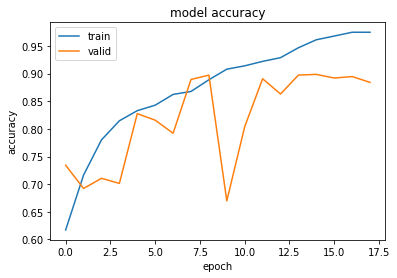

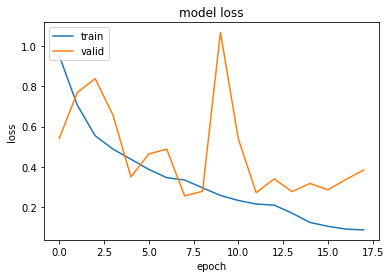

In [29]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='EarlyFusion')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'earlyFusion_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('earlyFusion_SQUARE_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_EarlyFusion.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"EarlyFusion", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

## Early Fusion Wide Kernel

====================Starting Split Number 0====================
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
You have passed in a tokenizer, we will just convert to sequences
filtering sentences
filtering sents and removing stopwords
Epoch 1/80
744/744 [==============================] - 70s 93ms/step - loss: 1.0122 - acc: 0.6070 - val_loss: 0.6243 - val_acc: 0.6776

Epoch 00001: val_loss improved from inf to 0.62427, saving model to earlyFusion_Wide_split_0.hd5
Epoch 2/80
744/744 [==============================] - 24s 32ms/step - loss: 0.8543 - acc: 0.6430 - val_loss: 0.5869 - val_acc: 0.7132

Epoch 00002: val_loss improved from 0.62427 to 0.58692, saving model to earlyFusion_Wide_split_0.hd5
Epoch 3/80
744/744 [==============================] - 23s 31ms/step - loss: 0.7188 - acc: 0.6

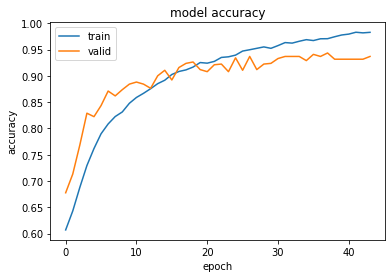

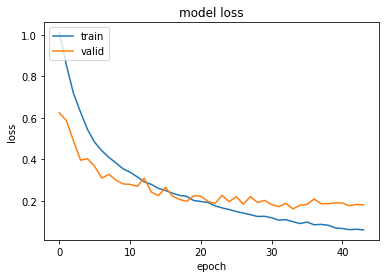

In [30]:
AUCList = []
report_list = []
for ix, split in data.items():
    K.clear_session()
    print('====================Starting Split Number {}===================='.format(ix))
    model = Generate_Model(model_type='EarlyFusion_Wide')#create model
    model.compile(optimizer=optimizerFactory(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    train_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['train'])].reset_index(drop=True), **params, aug=AUGMENTATIONS_TRAIN)
    valid_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['valid'])].reset_index(drop=True), **params)
    test_generator = indianaDataGenerator_DF(df[df['sample_id'].isin(data[str(ix)]['test'])].reset_index(drop=True), **params)
    
    #checkpoint
    filename = 'earlyFusion_Wide_split_{}.hd5'.format(ix)
    checkpoint = getCheckpointCallback(filename)
    
    history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), validation_data=valid_generator, 
                        validation_steps=len(valid_generator), workers=workers, epochs=n_epochs, verbose=fitVerbose, 
                        callbacks=[checkpoint,lrate,estopping])
    pd.DataFrame(history.history).to_csv('earlyFusion_WIDE_HISTORY_split_{}.csv'.format(ix))
    y_hat = model.predict_generator(test_generator, steps=len(test_generator), workers=workers)
    y_hat_class=y_hat.argmax(-1)
    y_true = ohe.transform(np.array(df[df['sample_id'].isin(data[str(ix)]['test'])]['normal']).reshape(-1, 1)).toarray()
    y_true_class = y_true.argmax(-1)
    pd.DataFrame(zip(y_true[:len(y_hat)].tolist(), y_hat.tolist()), columns=['y_true','y_hat']).to_csv('y_true_y_pred_chunk_{}_EarlyFusion_Wide.csv'.format(ix))
    #classification report
    cr = precision_recall_fscore_support(y_true_class[:len(y_hat)], y_hat_class,average='binary')
    #print(cr)
    report_list.append(pd.DataFrame([cr[:-1]], columns=['precision', 'recall','f1-score']))
    #area under curve
    auc = roc_auc_score(y_true[:len(y_hat)], y_hat)
    AUCList.append(auc)
    #print('AUC score for split {}: {}'.format(ix,auc))
    plot_history(history)
    
report_mean = pd.concat(report_list).mean()
model_stat_df = model_stat_df.append({'model':"EarlyFusion_Wide", 'f1-score': report_mean['f1-score'], 'precision':  report_mean['precision'],
                                     'recall': report_mean['recall'], 'AUC': np.mean(AUCList)},ignore_index=True)

In [31]:
model_stat_df.to_csv(path_or_buf="stats.csv", index=False)